# Fit p_features versus redshift for all galaxies in one go and evaluate models

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table,Column
from astropy.io import fits
from scipy import optimize
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import distributions as dist
import numpy as np
import os
import requests
import warnings
import matplotlib as mpl

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
# Use only galaxies with surface brightness/redshift ranges that are considered "debiasable"
# This table is computed in STEP 1 - p_features_thresholds_slope_method.ipynb

ferengi_filename = '../../data/ferengi_data_with_categories_new_sb.fits'

alldata = Table.read(ferengi_filename)    

data = alldata[alldata['Correctable_Category'] == 'correctable']

# Limit to galaxies that have data at z_sim = z0, since that's what we're normalizing to.
z0 = 0.3
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
eps = 1e-3
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < (z0+eps):
        z0ind[ind] = True
        
data_z0 = data[z0ind]

In [4]:
def fzeta_exp_mu_none(p,x,mu):
    return np.exp(-1 * (x-z0)/p[0])

def fzeta_exp_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    return np.exp(-1 * (x-z0)/q0)
    
def fzeta_epw_mu_none(p,x,mu):
    return np.exp(-1 * ((x-z0)/p[0])**p[1])

def fzeta_epw_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    q1 = p[2] + p[3]*mu
    return np.exp(-1 * ((x-z0)/q0)**q1)

def fzeta_lin_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0)

def fzeta_lin_mu_lin(p,x,mu):
    zeta = p[0] + p[1]*mu
    return 1 - zeta * (x-z0)

def fzeta_qud_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0) + p[1] * (x-z0)**2

def fzeta_qud_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    q1 = p[2] + p[3]*mu
    return 1 - q0 * (x-z0) + q1 * (x-z0)**2

def fzeta_cub_mu_none(p,x,mu):
    return 1 - p[0] * (x-z0) + p[1] * (x-z0)**2 + p[2] * (x-z0)**3

def fzeta_cub_mu_lin(p,x,mu):
    q0 = p[0] + p[1]*mu
    q1 = p[2] + p[3]*mu
    q2 = p[4] + p[5]*mu
    return 1 - q0 * (x-z0) + q1 * (x-z0)**2 + q2 * (x-z0)**3

def fzeta_pow_mu_none(p,x,mu):
    return p[0] ** (x-z0)/p[1]

def fzeta_pow_mu_lin(p,x,mu):
    q1 = p[0] + p[1]*mu
    q2 = p[2] + p[3]*mu
    return q1 ** ((x-z0)/q2)

def negloglike(p,func,x,mu,y):
    
    # Assuming a Normal scatter isn't ideal, since we know the value is bounded to (0,1).
    # Maybe some kind of beta function would be more suitable, but not bother with now.
    
    # Calculate the negative log-likelihood as the negative sum of the log of a normal
    # PDF where the observed values are normally distributed around the mean (yPred)
    # with a standard deviation of sd
    sd = p[-1]
    p = p[:-1]
    nll = -np.sum( stats.norm.logpdf(y, loc=func(p,x,mu), scale=sd) )
    return(nll)

def get_AIC(k,nll):
    log_likelihood = -nll
    AIC = 2*k - log_likelihood
    return AIC


In [5]:
# create dataset combining all galaxies

# get all unique galaxies
unique_galaxies = set(data['sdss_id'])

x = []
mu = []
y = []
yn = []
ym = []
yd = []

for gal in unique_galaxies:
    #loop over different evolutions for each galaxy
    this_galaxy = data[data['sdss_id']==gal]
    for evo in set(this_galaxy['sim_evolution']):
        # Find data for this galaxy at all redshifts  
        ind = this_galaxy['sim_evolution']==evo
        #Make sure minimum simulated redshift is 0.3; some were removed because of bad surface brightness measurments
        if np.min(this_galaxy[ind]['sim_redshift'])<0.4:
            #Store data for each galaxy/evo combination:
            galaxy = this_galaxy[ind]
            galaxy.sort('sim_redshift') #make sure data is in order, helps for plotting later
                
            #arrays for storing info:
            # set x,y
            
            y_abs = np.array(galaxy['p_features']) #unnormlaized p_features for galaxy
            p_at_3 = galaxy[galaxy['sim_redshift']==0.3]['p_features'][0]                
            if p_at_3 == 0:
                continue

            x.extend(galaxy['sim_redshift'])
            y.extend(y_abs) #normalized p_features  
            yn.extend(y_abs/p_at_3) #normalized p_features  
            ym.extend((p_at_3 - 1)/(y_abs - 1))
            yd.extend(y_abs - p_at_3) #normalized p_features  
            mu_at_3 = galaxy[galaxy['sim_redshift']==0.3]['GZ_MU_I'][0]
            mu.extend(mu_at_3 * np.ones_like(y_abs))
            
x = np.asarray(x)
mu = np.asarray(mu)
y = np.asarray(y)   # no normalisation: f(z)
yn = np.asarray(yn) # normalised: f(z) / f(z0)
ym = np.asarray(ym) # normalised as eqn. 4 in paper: (f(z0)-1)/(f(z)-1)
yd = np.asarray(yd) # subtracted: f(z) - f(z0)

In [6]:
def fit_and_plot(x, y, mu, func, n, cmap='jet'):
    p0 = [0.5, 0.01, 0.5, 0.01, 0.5, 0.01, 0.5]
    # DON'T INCLUDE FIRST POINT (AT Z=Z0) SINCE IT IS USED TO NORMALIZE DATA.
    p = minimize(negloglike, p0[:n], args=(func, x[1:], mu[1:], y[1:]), method='nelder-mead')
    jet = cm = plt.get_cmap(cmap) 
    cNorm  = mpl.colors.Normalize(vmin=mu.min(), vmax=mu.max())
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
    plt.scatter(x + np.random.normal(0, 0.01, len(x)), y, s=5, c=mu, edgecolor='none',
                norm=cNorm, cmap=cmap)
    xfit = np.linspace(x.min(), x.max(), 100)
    mufit = np.linspace(mu.min(), mu.max(), 5)[1:-1]
    for mu in mufit:
        yfit = func(p.x, xfit, mu)
        plt.plot(xfit, yfit, '-', color=scalarMap.to_rgba(mu))
    plt.ylim(0, 2)
    plt.colorbar()
    print(p.x)
    aic = get_AIC(n, p.fun)
    print(aic)

## Using simple normalisation: f(z)/f(z0)

## $f=e^(z-z_0)$

[ 0.5162802   0.37919333]
748.396300465


/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


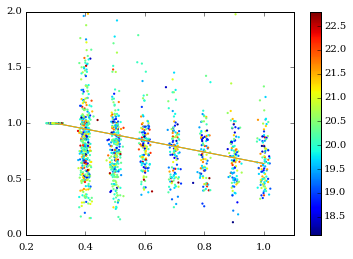

In [7]:
fit_and_plot(x, yn, mu, fzeta_lin_mu_none, 2)

[ 1.04267711 -0.0261725   0.37910989]
750.004599105


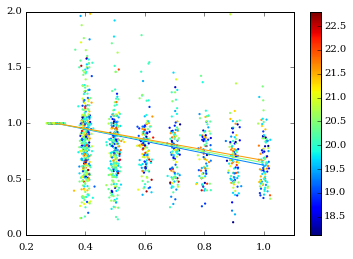

In [8]:
fit_and_plot(x, yn, mu, fzeta_lin_mu_lin, 3)

[ 1.62564994  0.37855449]
745.528686818


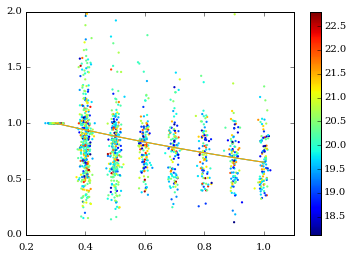

In [9]:
fit_and_plot(x, yn, mu, fzeta_exp_mu_none, 2)

[-0.16694409  0.08930555  0.37846156]
747.171442903


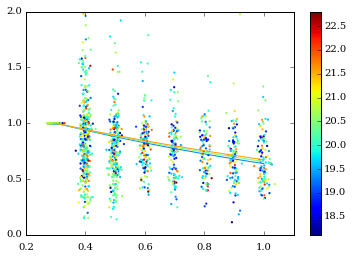

In [10]:
fit_and_plot(x, yn, mu, fzeta_exp_mu_lin, 3)

[ 0.8624505   0.65071015  0.37765199]
743.602804337


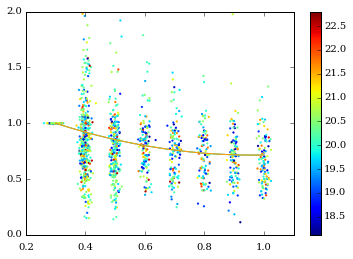

In [11]:
fit_and_plot(x, yn, mu, fzeta_qud_mu_none, 3)

[ 1.03041365 -0.00821826 -0.21173344  0.04316441  0.37751328]
747.015705532


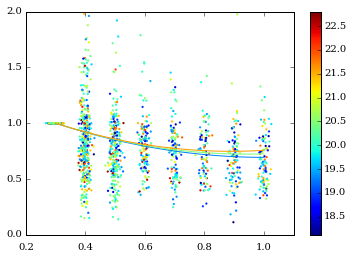

In [12]:
fit_and_plot(x, yn, mu, fzeta_qud_mu_lin, 5)

[ 0.72623993  0.04857103  0.59110294  0.37784676]
746.493301714


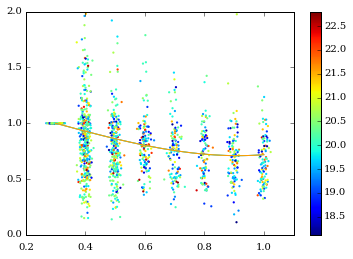

In [13]:
fit_and_plot(x, yn, mu, fzeta_cub_mu_none, 4)

[-1.26199981  0.11661149 -7.56610878  0.46528424  5.33532864 -0.32681573
  0.37746889]
750.040876915


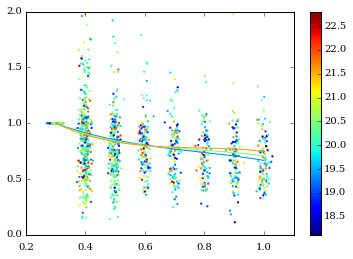

In [14]:
fit_and_plot(x, yn, mu, fzeta_cub_mu_lin, 7)

[ 0.57904144  1.026514    0.37816773]
745.855640548


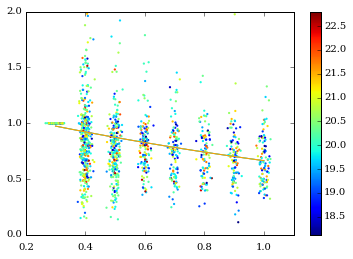

In [15]:
fit_and_plot(x, yn, mu, fzeta_pow_mu_none, 3)

[ 0.32211557  0.0134857   0.61376109  0.01169319  0.3784594 ]
751.155817596


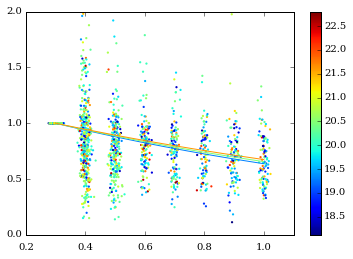

In [16]:
fit_and_plot(x, yn, mu, fzeta_pow_mu_lin, 5)

[ 3.37404315  0.6449756   0.37749397]
742.938078136


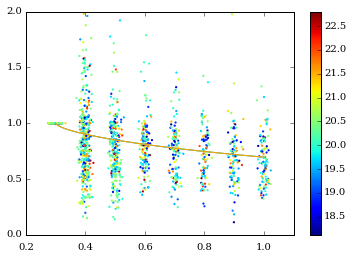

In [17]:
fit_and_plot(x, yn, mu, fzeta_epw_mu_none, 3)

[-9.64047853  0.64948499  1.44681224 -0.03965669  0.37735705]
746.329327362


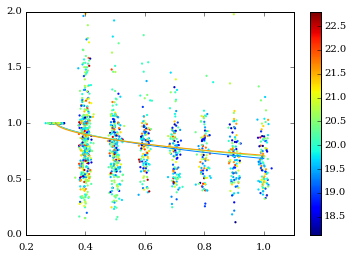

In [18]:
fit_and_plot(x, yn, mu, fzeta_epw_mu_lin, 5)

## Using alternative normalisation, as in eqn. 4: (f(z0)-1) / (f(z)-1)

[ 0.69900893  0.23124561]
-71.0728625198


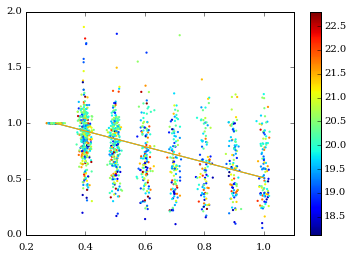

In [19]:
fit_and_plot(x, ym, mu, fzeta_lin_mu_none, 2)

[ 1.23349605 -0.02657426  0.23110115]
-70.1590795572


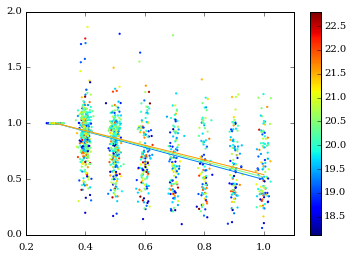

In [20]:
fit_and_plot(x, ym, mu, fzeta_lin_mu_lin, 3)

[ 1.12043256  0.22880658]
-88.6501467096


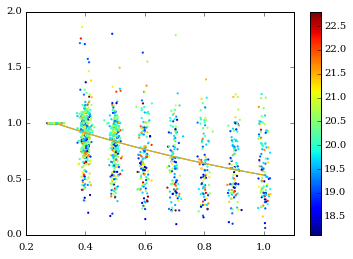

In [21]:
fit_and_plot(x, ym, mu, fzeta_exp_mu_none, 2)

[-1.0961157   0.1106533   0.22847749]
-89.0754205842


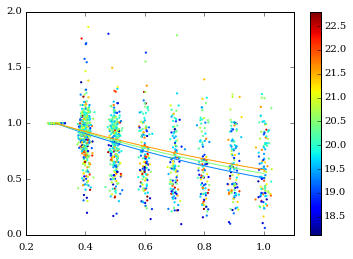

In [22]:
fit_and_plot(x, ym, mu, fzeta_exp_mu_lin, 3)

[ 1.14319587  0.83500858  0.22703556]
-99.5780253403


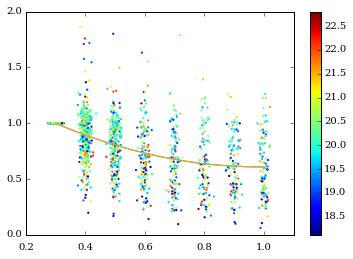

In [23]:
fit_and_plot(x, ym, mu, fzeta_qud_mu_none, 3)

[ 1.7531446  -0.03009891  0.7357606   0.00536674  0.22679691]
-97.3091950931


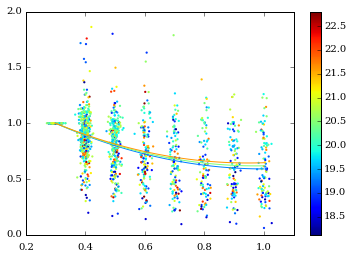

In [24]:
fit_and_plot(x, ym, mu, fzeta_qud_mu_lin, 5)

[ 0.96884376 -0.05841807  0.96587592  0.22689882]
-98.5820776738


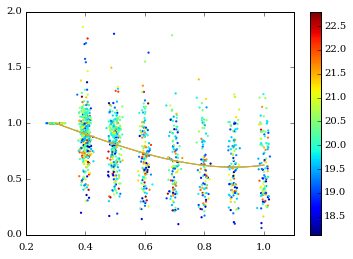

In [25]:
fit_and_plot(x, ym, mu, fzeta_cub_mu_none, 4)

[ 1.38012784 -0.01924414 -0.32824092  0.01885874  0.6597872   0.00983051
  0.22666584]
-94.2640510119


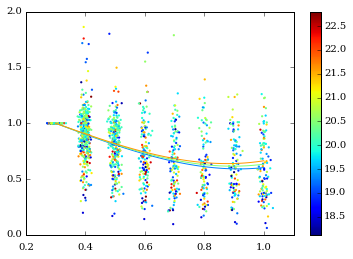

In [26]:
fit_and_plot(x, ym, mu, fzeta_cub_mu_lin, 7)

[ 0.4267361   1.01464752  0.22861642]
-88.0100570232


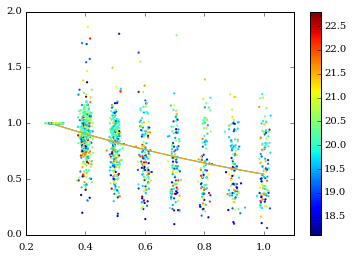

In [27]:
fit_and_plot(x, ym, mu, fzeta_pow_mu_none, 3)

[ 2.99465051 -0.13107071 -9.53362066  0.5381498   0.22511455]
-109.646252919


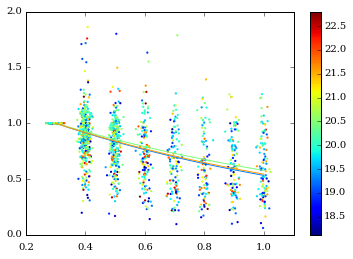

In [28]:
fit_and_plot(x, ym, mu, fzeta_pow_mu_lin, 5)

[ 1.44128699  0.79800133  0.2278697 ]
-93.5264350925


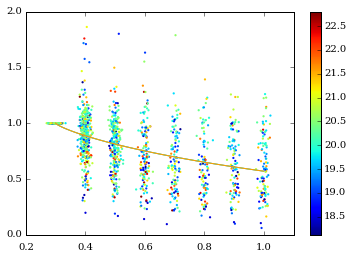

In [29]:
fit_and_plot(x, ym, mu, fzeta_epw_mu_none, 3)

[ 0.93803864  0.02614353  0.04070609  0.0371312   0.2275924 ]
-91.5049790248


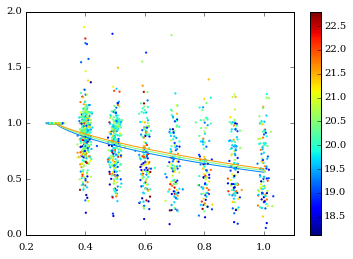

In [30]:
fit_and_plot(x, ym, mu, fzeta_epw_mu_lin, 5)